### Notebook 5: Modelling the NLP Problem using RandomForestClassifier

In this notebook I will experiment with RandomForest hyperparameter testing to try to acheive the best model that can discern which subreddit a submission title corresponds to.

Step 1: Imports and my model evaluation functions to make life easier.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, confusion_matrix

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

import warnings
warnings.filterwarnings('ignore')

In [2]:
def eval_model(pipe, X_train, X_test, y_train, y_test):
    """function for evaluating a model inside of a pipeline."""
#     y_train_preds = pipe.predict(X_train)
#     rmse_train = mean_squared_error(y_train, y_train_preds, squared=False)
    y_test_preds = pipe.predict(X_test)
#     rmse_test = mean_squared_error(y_test, y_test_preds, squared=False)
    print(f'Your train score is: {cross_val_score(pipe, X_train, y_train)}')
    print(f'Your mean train score is: {np.mean(cross_val_score(pipe, X_train, y_train))}')
    print(f'Your test score is: {cross_val_score(pipe, X_test, y_test)}')
    print(f'Your mean test score is: {np.mean(cross_val_score(pipe, X_test, y_test))}')
    print(f'Your test recall/sensitivity score is: {recall_score(y_test, y_test_preds)}')
    print(f'Your confusion matrix is: {confusion_matrix(y_test, y_test_preds, normalize = "true")}')
#     print(f'Your train RMSE is: {rmse_train}')
#     print(f'Your test RMSE is: {rmse_test}')

In [3]:
def pipe_coefs(pipe, vectorizer):
    """ This function will give you a dataframe with your features and their coefficients/importances so you can sort them"""
    features = pipe.named_steps[vectorizer].get_feature_names()
    coefficients = pipe.named_steps['randomforestclassifier'].feature_importances_
    #flattened_coefs = [val for sublist in coefficients for val in sublist]
    pipe_coefs_df = pd.DataFrame({'coefs': coefficients, 'names': features})
    return pipe_coefs_df

In [4]:
def eval_model_gs(gs, X_train, X_test, y_train, y_test):
    """function to get the model results when using GridSearchCV"""
#     y_train_preds = gs.predict(X_train)
#     rmse_train = mean_squared_error(y_train, y_train_preds, squared=False)
    y_test_preds = gs.predict(X_test)
#     rmse_test = mean_squared_error(y_test, y_test_preds, squared=False)
    print(f'Your train score is: {gs.score(X_train, y_train)}')
    print(f'Your test score is: {gs.score(X_test, y_test)}')
    print(f'Your best test params were: {gs.best_params_}')
    print(f'Your test recall/sensitivity score is: {recall_score(y_test, y_test_preds)}')
    print(f'Your confusion matrix is: {confusion_matrix(y_test, y_test_preds, normalize = "true")}')
#     print(f'Your train RMSE is: {rmse_train}')
#     print(f'Your test RMSE is: {rmse_test}')

In [5]:
def get_coefs_gs(gs, vectorizer):
    """function to get the coefficients when using GridSearchCV"""
    feats = gs.best_estimator_.named_steps[vectorizer].get_feature_names()
    imports = gs.best_estimator_.named_steps['randomforestclassifier'].feature_importances_
    import_feats_df = pd.DataFrame({'imports': imports, 'features': feats})
    return import_feats_df

In [6]:
class LemmaTokenizer:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.lemmatizer.lemmatize(t) for t in word_tokenize(doc)]

Step 2: Read in the combined and cleaned dataset I saved in Notebook 2

In [7]:
token_titles = pd.read_csv('./data/combined_data_cleaned_with_regexp.csv', index_col=0)

In [8]:
token_titles.head()

,subreddit,title,title_word_length,title_character_total,subreddit_map,title_token
0,gameofthrones,Some genius explains how the Trump riots is ‘G...,14,78,1,Some genius explains how the Trump riots is Ga...
1,gameofthrones,"Jagjeet Sandhu Age, Career, Personal Life- Bio...",25,160,1,Jagjeet Sandhu Age Career Personal Life Biogra...
2,gameofthrones,"Kaagaz: plot, cast, review. Kaagaz is a 2021 I...",21,129,1,Kaagaz plot cast review Kaagaz is a 2021 India...
3,gameofthrones,"Urvi Singh Age, Career, Personal Life- Biograp...",24,156,1,Urvi Singh Age Career Personal Life Biography ...
4,gameofthrones,"Abhishek Banerjee: Wiki, age, birthday &amp; f...",23,154,1,Abhishek Banerjee Wiki age birthday amp facts ...


In [9]:
token_titles.shape

(10200, 6)

In [10]:
token_titles.isna().sum()

subreddit                 0
title                     0
title_word_length         0
title_character_total     0
subreddit_map             0
title_token              76
dtype: int64

In [11]:
token_titles = token_titles.dropna()

In [12]:
token_titles.isna().sum()

subreddit                0
title                    0
title_word_length        0
title_character_total    0
subreddit_map            0
title_token              0
dtype: int64

Going to set up X and y and do a train_test_split on the data.

In [13]:
X = token_titles['title_token']
y = token_titles['subreddit_map']

In [14]:
y.value_counts(normalize=True)

0    0.503062
1    0.496938
Name: subreddit_map, dtype: float64

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

Now, onto the modelling! BEWARE: "The night is dark, and full of terrors"

In [16]:
forest_pipe1 = make_pipeline(CountVectorizer(stop_words='english', max_features = 1000), RandomForestClassifier())

In [17]:
forest_pipe1.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=1000, stop_words='english')),
                ('randomforestclassifier', RandomForestClassifier())])

In [18]:
eval_model(forest_pipe1, X_train, X_test, y_train, y_test)

Your train score is: [0.90980908 0.94009217 0.91770902 0.93280632 0.90777339]
Your mean train score is: 0.9230869244293409
Your test score is: [0.9270217  0.91106719 0.9229249  0.92885375 0.92687747]
Your mean test score is: 0.9249300309500977
Your test recall/sensitivity score is: 0.9176379176379177
Your confusion matrix is: [[0.95659164 0.04340836]
 [0.08236208 0.91763792]]


Nice first-pass model here. I'm going to test some hyperparameters with a GridSearchCV.

In [19]:
forest_pipe2 = make_pipeline(CountVectorizer(), RandomForestClassifier())

In [20]:
params2 = {'countvectorizer__stop_words': ['english'],
          'countvectorizer__max_features': [1000],
        'randomforestclassifier__n_estimators': [50, 100, 500],
         'randomforestclassifier__max_depth': [2,3,4,5],
         'randomforestclassifier__criterion': ['gini', 'entropy'],
         'randomforestclassifier__ccp_alpha': [0.01, 0.1, 1.0, 10.0]}

In [21]:
forest_grid2 = GridSearchCV(forest_pipe2, param_grid = params2, n_jobs=-1)

In [22]:
forest_grid2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_features': [1000],
                         'countvectorizer__stop_words': ['english'],
                         'randomforestclassifier__ccp_alpha': [0.01, 0.1, 1.0,
                                                               10.0],
                         'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__max_depth': [2, 3, 4, 5],
                         'randomforestclassifier__n_estimators': [50, 100,
                                                                  500]})

In [23]:
eval_model_gs(forest_grid2, X_train, X_test, y_train, y_test)

Your train score is: 0.8613196365073094
Your test score is: 0.860924535756618
Your best test params were: {'countvectorizer__max_features': 1000, 'countvectorizer__stop_words': 'english', 'randomforestclassifier__ccp_alpha': 0.01, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 100}
Your test recall/sensitivity score is: 0.7303807303807304
Your confusion matrix is: [[0.99598071 0.00401929]
 [0.26961927 0.73038073]]


In [24]:
grid2_feats = get_coefs_gs(forest_grid2, 'countvectorizer')
grid2_feats

,imports,features
0,0.0,10
1,0.0,100
2,0.0,11
3,0.0,12
4,0.0,13
...,...,...
995,0.0,years
996,0.0,yes
997,0.0,yesterday
998,0.0,young


In [25]:
grid2_feats.nlargest(20, 'imports')

,imports,features
818,0.129108,spoilers
5,0.082390,14
123,0.060492,bigg
529,0.055123,lotr
141,0.038396,boss
732,0.032143,roadies
298,0.028294,episode
423,0.026523,hobbit
34,0.023123,4k
725,0.022695,revolution


In [26]:
grid2_feats.nsmallest(10, 'imports')

,imports,features
0,0.0,10
1,0.0,100
2,0.0,11
3,0.0,12
4,0.0,13
6,0.0,16
7,0.0,17
8,0.0,19
9,0.0,1991
10,0.0,1992


Now I'd like to run the best features of this model, but testing the ngrams again in the CountVectorizer. I just want to see if the RandomForest model does any better with those.

In [27]:
forest_pipe3 = make_pipeline(CountVectorizer(), RandomForestClassifier())

In [28]:
params3 = {'countvectorizer__stop_words': ['english'],
          'countvectorizer__max_features': [1000],
          'countvectorizer__ngram_range': [(1,1), (1,2), (1,3)],
        'randomforestclassifier__n_estimators': [500],
         'randomforestclassifier__max_depth': [5],
         'randomforestclassifier__criterion': ['entropy'],
         'randomforestclassifier__ccp_alpha': [0.01]}

In [29]:
forest_grid3 = GridSearchCV(forest_pipe3, param_grid = params3, n_jobs=-1)

In [30]:
forest_grid3.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_features': [1000],
                         'countvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)],
                         'countvectorizer__stop_words': ['english'],
                         'randomforestclassifier__ccp_alpha': [0.01],
                         'randomforestclassifier__criterion': ['entropy'],
                         'randomforestclassifier__max_depth': [5],
                         'randomforestclassifier__n_estimators': [500]})

In [31]:
eval_model_gs(forest_grid3, X_train, X_test, y_train, y_test)

Your train score is: 0.871460555775056
Your test score is: 0.8711971552745951
Your best test params were: {'countvectorizer__max_features': 1000, 'countvectorizer__ngram_range': (1, 1), 'countvectorizer__stop_words': 'english', 'randomforestclassifier__ccp_alpha': 0.01, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 500}
Your test recall/sensitivity score is: 0.7505827505827506
Your confusion matrix is: [[0.99598071 0.00401929]
 [0.24941725 0.75058275]]


In [32]:
#My score is quite a bit lower. Let me try that model again, without the RandomForest params

In [33]:
params3b = {'countvectorizer__stop_words': ['english'],
          'countvectorizer__max_features': [1000],
          'countvectorizer__ngram_range': [(1,1), (1,2), (1,3)]}

In [34]:
forest_grid3b = GridSearchCV(forest_pipe3, param_grid = params3b, n_jobs=-1)

In [35]:
forest_grid3b.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_features': [1000],
                         'countvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)],
                         'countvectorizer__stop_words': ['english']})

In [36]:
eval_model_gs(forest_grid3b, X_train, X_test, y_train, y_test)

Your train score is: 0.9803766627156592
Your test score is: 0.9340181746345319
Your best test params were: {'countvectorizer__max_features': 1000, 'countvectorizer__ngram_range': (1, 1), 'countvectorizer__stop_words': 'english'}
Your test recall/sensitivity score is: 0.9176379176379177
Your confusion matrix is: [[0.95096463 0.04903537]
 [0.08236208 0.91763792]]


In [37]:
#Hmm look at that- my scores improved AND it liked n_gram = (1,2). Let's look at the important features here.

In [38]:
grid3b_feats = get_coefs_gs(forest_grid3b, 'countvectorizer')

In [39]:
grid3b_feats.nlargest(20, 'imports')

,imports,features
818,0.203275,spoilers
5,0.050042,14
123,0.029065,bigg
141,0.027292,boss
529,0.026484,lotr
761,0.026386,season
817,0.020337,spoiler
880,0.016414,thrones
298,0.014403,episode
732,0.013959,roadies


Glad to see the model improved. Still no success in seeing "Winter is coming" though... Oh well.

Now I'd like to use TfidfVectorizer and see if that does anything different.

In [40]:
forest_pipe4 = make_pipeline(TfidfVectorizer(stop_words = 'english', max_features = 1000, ngram_range=(1,2)), RandomForestClassifier())

In [41]:
forest_pipe4.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=1000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('randomforestclassifier', RandomForestClassifier())])

In [42]:
eval_model(forest_pipe4, X_train, X_test, y_train, y_test)

Your train score is: [0.91046741 0.93811718 0.92363397 0.93544137 0.91963109]
Your mean train score is: 0.9257217970702243
Your test score is: [0.93293886 0.90909091 0.92885375 0.93083004 0.93478261]
Your mean test score is: 0.9261150221016441
Your test recall/sensitivity score is: 0.9083139083139083
Your confusion matrix is: [[0.96945338 0.03054662]
 [0.09168609 0.90831391]]


In [43]:
forest_pipe4_feats = pipe_coefs(forest_pipe4, 'tfidfvectorizer')

In [44]:
forest_pipe4_feats.nlargest(20, 'coefs')

,coefs,names
824,0.214940,spoilers
6,0.045874,14
770,0.027174,season
823,0.023236,spoiler
541,0.023105,lotr
139,0.020661,bigg boss
138,0.019716,bigg
162,0.016001,boss
313,0.014746,episode
163,0.014713,boss 14


In [45]:
forest_pipe5 = make_pipeline(TfidfVectorizer(tokenizer = LemmaTokenizer(), stop_words = 'english', max_features = 1000), RandomForestClassifier())

In [46]:
forest_pipe5.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=1000, stop_words='english',
                                 tokenizer=<__main__.LemmaTokenizer object at 0x7fa09176aa60>)),
                ('randomforestclassifier', RandomForestClassifier())])

In [47]:
eval_model(forest_pipe5, X_train, X_test, y_train, y_test)

Your train score is: [0.92034233 0.93877551 0.92560895 0.9400527  0.92555995]
Your mean train score is: 0.9299361361272803
Your test score is: [0.93688363 0.91304348 0.91501976 0.95059289 0.93083004]
Your mean test score is: 0.9284850044047369
Your test recall/sensitivity score is: 0.9098679098679099
Your confusion matrix is: [[0.9766881  0.0233119 ]
 [0.09013209 0.90986791]]


In [48]:
forest_pipe5_coefs = pipe_coefs(forest_pipe5, 'tfidfvectorizer')

In [49]:
top_pipe5_feats = forest_pipe5_coefs.nlargest(10, 'coefs')

In [50]:
top_pipe5_feats

,coefs,names
823,0.219481,spoiler
6,0.056589,14
769,0.028059,season
132,0.026300,bigg
148,0.025580,bos
883,0.020760,throne
532,0.020618,lotr
307,0.014376,episode
739,0.013799,ring
741,0.012020,roadies


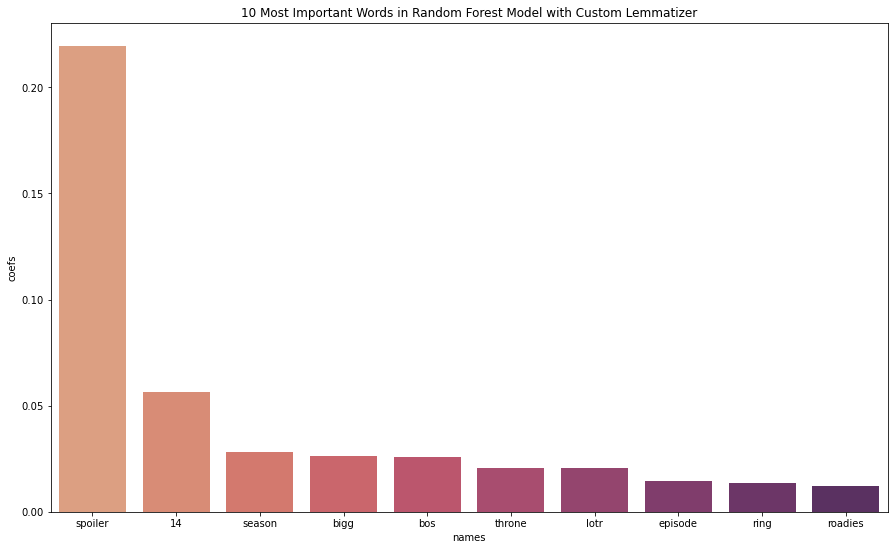

In [51]:
ax, fig = plt.subplots(figsize = (15, 9))

sns.barplot(x="names", y="coefs", data=top_pipe5_feats,
                 palette="flare")

plt.title('10 Most Important Words in Random Forest Model with Custom Lemmatizer');

Okay, well it doesn't appear that using the custom Lemmatizer improved our scores much, but I think it was worth doing.

It looks like my best model was with pipe5, because it had similar test scores (~93%) as some of the other runs, but very little overfitting. The Recall Score was pretty good at .91 and our false negatives were quite low at .09. The parameters in this model were the TfidfVectorizer with custom lemmatizer, stop_words = 'english', max_features = 1000, n_grams = (1,2), and just the defaults used on the RandomForestClassifier. I also like this model best because the lemmatizer reduces some of the important features to their roots. For example, I was thinking of using forest_pipe4 as my best model, but when I looked at the top features, I noticed that both 'spoiler' and 'spoilers' made the top 10. So, althought my test scores were more or less the same, I don't want duplicate features in my top 10. So, I'm going with forest_pipe5 and I will make a chart showing the most important features here for my presentation. 

To conclude this project, it looks like I'm getting pretty similar results between the Naive Bayes Model and the Random Forest Classifier Models, and what is interesting is that many of the same words/features end up in both models. So, I think I will be able to successfully help my Game of Thrones Subreddit Moderator friend filter out those pesky Lord of the Ring posts on her GoT page by using this model. I should be able to filter out the LOTR posts with ~93-94% accuracy. I recommend using a RandomForest Classifier Model with WordNet Lemmatizer and a TfidfVectorizer. Huzzah!

For future work, I'd like to experiment with additional model types, like Logistic Regression, and SVM Classifier. I'd also have liked to utilize the ROC-AUC score and plots since I was optimizing for Sensitivity/Recall. It might have been a useful metric for me to visualize as I went. Finally, I think it would have beem fun to try running a Sentiment Analyzer on the posts to see if there was a difference between the two. I wonder if that could have been a good feature in my model to test. There's always more one can do! 